In [1]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, MolFromSmiles, rdFingerprintGenerator 

from chython import smiles
from collections import defaultdict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

import pytorch_lightning as pyl

from torch.utils.data import Dataset, DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools

In [214]:
train_data = pd.read_csv('D:\Python\СИбур_хак_07.04.2025\sibur_element_119_final_train_data80.csv')
test_data = pd.read_csv('D:\Python\СИбур_хак_07.04.2025\sibur_element_119_final_test_data80.csv')

In [215]:
train_data

,ID,SMILES,LogP
0,0,C1(NON=C1C2=CC=CC=C2)=N,3.093
1,1,C=1C=CC=CC=1CC(NC=2C=CC(=CC=2)Br)=O,5.245
2,2,C(C)C1=CC=CS1,4.294
3,3,N1C=CNC1=NC2C(OC)=NC(=NC2Cl)C,2.254
4,4,CC(C)CCO,1.939
...,...,...,...
13398,13398,CC(C)COC(=O)NC1=CC=C(OCC)C(=C1)OCC,4.704
13399,13399,C(C=1C(NC(=O)C)=CC=C(Br)C=1)CZ,5.183
13400,13400,C(O)(COC(C(C)=C)=O)C,2.566
13401,13401,O=S(=O)(C=1C(C(OC)=O)=CC=CC=1)NC(N=C2N=C(C)NC(...,3.694


In [ ]:
PandasTools.AddMoleculeColumnToFrame(train_data,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_data,'SMILES','Molecule')

In [218]:
df_train = train_data.dropna()
df_test = test_data.dropna()

In [219]:
smiles_1 = df_train['SMILES'].tolist()
smiles_2 = df_test['SMILES'].tolist()

In [221]:
# Параметры фингерпринта
radius = 2
n_bits = 2048

# Инициализация генератора Моргана
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)

# Функция для получения фингерпринта по SMILES
def get_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Получаем фингерпринт как numpy-массив (bool)
        fp = morgan_generator.GetFingerprintAsNumPy(mol)
        return np.array(fp, dtype=int)  # int для удобства в ML
    else:
        return np.full(n_bits, np.nan)  # некорректный SMILES → NaN

In [222]:
fingerprints_1 = []
fingerprints_2 = []

In [223]:
fingerprints_1 = [get_morgan_fingerprint(s) for s in smiles_1]
fingerprints_2 = [get_morgan_fingerprint(s) for s in smiles_2]

In [225]:
fingerprints_array_1 = np.array(fingerprints_1)
fingerprints_array_2 = np.array(fingerprints_2)

In [226]:
#train_data['fingerprint'] = fingerprints
fp_df_1 = pd.DataFrame(fingerprints_array_1, columns=[f'fp_{i}' for i in range(fingerprints_array_1.shape[1])])

# Объединяем с исходным train_data по колонкам
train_data_with_fp = pd.concat([df_train.reset_index(drop=True), fp_df_1], axis=1)

In [227]:
fp_df_2 = pd.DataFrame(fingerprints_array_2, columns=[f'fp_{i}' for i in range(fingerprints_array_2.shape[1])])

# Объединяем с исходным train_data по колонкам
test_data_with_fp = pd.concat([df_test.reset_index(drop=True), fp_df_2], axis=1)

In [228]:
train_data_with_fp = train_data_with_fp.drop(columns = ['Molecule'])
test_data_with_fp = test_data_with_fp.drop(columns = ['Molecule'])

In [229]:
test_data_with_fp

,ID,SMILES,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,13403,CC(C)OC=1C(=C(N(C)C=1C(N=C2NNN=N2)=O)Br)Br,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13404,C12(C(CCC1(C(=O)COC(=O)CC)O)C3C(C(O)C2)C4(CCC(...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13405,C1(=C([N+]([O-])=CC=N1)C2=CC=C(Br)C=C2)C3=CC=C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13406,C1C2(C(C(C1O)C=3CC(=O)OC=3)(C)CCC4C2CCC5C4(CCC...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13407,ClC1(Cl)C2(C(=C(C1(Cl)C3C2C4OC4C3Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,16028,BrC(Br)(Br)C(=O)NC(C(O)C1=CC=C(C=C1)[N+](=O)[O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2626,16029,O=S(=O)(NCCOCCSC=1C=CC=CC=1)CCCNCCC=2C3=C(NC(=...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2627,16030,CC(C)(C)C(=O)OCOC(=O)C1N2C(C(C2=O)NC(CC3=CSC(=...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2628,16031,CC(C)(C)C(=O)OCOC(C1N2C(=O)C(NC(=O)CN3N=NN=C3)...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
y = train_data_with_fp['LogP'].values
y = y.reshape(-1,1)
scaler = StandardScaler()
y = scaler.fit_transform(y)
y

array([[-0.20194101],
       [ 0.7230756 ],
       [ 0.31429735],
       ...,
       [-0.42846692],
       [ 0.05639309],
       [-1.9187237 ]])

In [231]:
test_data_with_fp

,ID,SMILES,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,13403,CC(C)OC=1C(=C(N(C)C=1C(N=C2NNN=N2)=O)Br)Br,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13404,C12(C(CCC1(C(=O)COC(=O)CC)O)C3C(C(O)C2)C4(CCC(...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13405,C1(=C([N+]([O-])=CC=N1)C2=CC=C(Br)C=C2)C3=CC=C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13406,C1C2(C(C(C1O)C=3CC(=O)OC=3)(C)CCC4C2CCC5C4(CCC...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13407,ClC1(Cl)C2(C(=C(C1(Cl)C3C2C4OC4C3Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,16028,BrC(Br)(Br)C(=O)NC(C(O)C1=CC=C(C=C1)[N+](=O)[O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2626,16029,O=S(=O)(NCCOCCSC=1C=CC=CC=1)CCCNCCC=2C3=C(NC(=...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2627,16030,CC(C)(C)C(=O)OCOC(=O)C1N2C(C(C2=O)NC(CC3=CSC(=...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2628,16031,CC(C)(C)C(=O)OCOC(C1N2C(=O)C(NC(=O)CN3N=NN=C3)...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
X_train_1 = train_data_with_fp.drop(columns = ['SMILES', 'LogP'])
X_test_1 = test_data_with_fp.drop(columns = ['SMILES'])

In [233]:
X_train_1

,ID,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12948,13397,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12949,13398,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12950,13400,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12951,13401,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def mol_dsc_calc1(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

#список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"Chi0": Descriptors.Chi0,
               "Chi1": Descriptors.Chi1,
               "Chi2n": Descriptors.Chi2n,
                "Kappa1": Descriptors.Kappa1,
                "Kappa2": Descriptors.Kappa2,
                "Kappa3": Descriptors.Kappa3,
                "FractionCSP3": Descriptors.FractionCSP3,
               "LabuteASA": Descriptors.LabuteASA,
               "PEOE_VSA1": Descriptors.PEOE_VSA1,
               "PEOE_VSA9": Descriptors.PEOE_VSA9,
               "SMR_VSA1": Descriptors.SMR_VSA1,
               "NumAliphaticRings": Descriptors.NumAliphaticRings,
               "NumSaturatedHeterocycles": Descriptors.NumSaturatedHeterocycles,
               "NumSaturatedRings": Descriptors.NumSaturatedRings,
               "LogP": Descriptors.MolLogP}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc1)
X_train_2 = descriptors_transformer.transform(train_data_with_fp['SMILES'])
X_test_2 = descriptors_transformer.transform(test_data_with_fp['SMILES'])

In [235]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

 #список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA,
                #"LogP": Descriptors.MolLogP
                }

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X_train_3 = descriptors_transformer.transform(train_data_with_fp['SMILES'])


In [236]:
X_test_3 = descriptors_transformer.transform(test_data_with_fp['SMILES'])

In [237]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [238]:
X_comb_train_1 = pd.concat([X_train_1,X_train_2], axis = 1)
X_comb_test_1 = pd.concat([X_test_1,X_test_2], axis = 1)
X_comb_train = pd.concat([X_comb_train_1,X_train_3], axis = 1)
X_comb_test = pd.concat([X_comb_test_1,X_test_3], axis = 1)

In [239]:
X_comb_train

,ID,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,MR,TPSA
0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,60,2,0,2,161.164,42.1444,65.67
1,1,0,0,0,0,0,0,0,0,0,...,1,3,3,86,2,0,2,290.160,72.9177,29.10
2,2,0,0,0,0,0,0,0,0,0,...,0,1,1,38,1,0,1,112.197,33.6970,0.00
3,3,0,0,0,0,0,0,0,0,0,...,2,7,1,86,1,1,2,241.682,61.6884,77.89
4,4,0,1,0,0,0,0,0,0,0,...,1,1,2,38,0,0,0,88.150,26.5408,20.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12948,13397,0,0,0,0,0,0,0,0,0,...,1,2,3,54,1,0,1,136.198,41.6177,24.92
12949,13398,0,1,0,0,0,0,0,0,0,...,1,5,7,112,1,0,1,281.352,78.5887,56.79
12950,13400,0,1,0,0,0,0,0,0,0,...,1,3,3,58,0,0,0,144.170,37.4538,46.53
12951,13401,0,0,0,0,0,0,0,0,0,...,2,12,4,138,2,0,2,381.370,86.7337,152.70


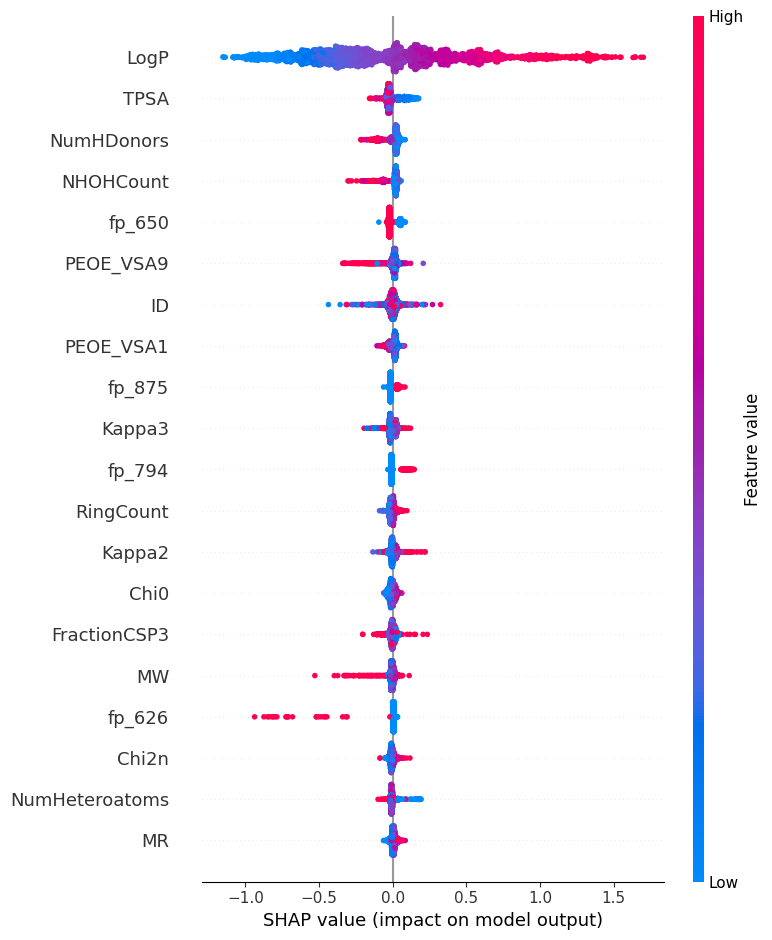

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=20)

In [242]:
# Если shap_values — это массив (n_samples, n_features)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Среднее абсолютное влияние каждого признака
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Сформируем датафрейм
important_features_df = pd.DataFrame({
    'Feature': mean_abs_shap.index,
    'MeanAbsSHAP': mean_abs_shap.values
})

# Посмотрим топ-20
print(important_features_df.head(100))

       Feature  MeanAbsSHAP
0         LogP     0.441084
1         TPSA     0.039457
2   NumHDonors     0.034841
3    NHOHCount     0.034191
4       fp_650     0.030231
..         ...          ...
95     fp_1168     0.001875
96     fp_1911     0.001874
97        fp_1     0.001868
98     fp_1274     0.001710
99     fp_1060     0.001683

[100 rows x 2 columns]


In [243]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_comb_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


        Feature  Importance
2063       LogP   37.491555
0            ID    5.202153
2058  PEOE_VSA9    2.504503
627      fp_626    2.126200
2065  NHOHCount    1.752094
...         ...         ...
463      fp_462    0.000000
1262    fp_1261    0.000000
1263    fp_1262    0.000000
1266    fp_1265    0.000000
7          fp_6    0.000000

[2078 rows x 2 columns]


In [ ]:
threshold = 0.0015

In [245]:
very_important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']
X_filtered = X_comb_train[very_important_features]

In [246]:
very_important_features_df = important_features_df[important_features_df['MeanAbsSHAP'] > threshold]['Feature']

In [247]:
very_important_features_df

0            LogP
1            TPSA
2      NumHDonors
3       NHOHCount
4          fp_650
          ...    
103        fp_899
104       fp_1928
105         fp_80
106        fp_849
107       fp_1476
Name: Feature, Length: 108, dtype: object

In [248]:
X_filtered_1 = X_comb_train[very_important_features_df]

In [251]:
X_filtered_1_test = X_comb_test[very_important_features_df]

In [249]:
X_filtered_1

,LogP,TPSA,NumHDonors,NHOHCount,fp_650,PEOE_VSA9,ID,PEOE_VSA1,fp_875,Kappa3,...,fp_1274,fp_1060,fp_305,fp_207,fp_1243,fp_899,fp_1928,fp_80,fp_849,fp_1476
0,1.14917,65.67,2,2,0,0.000000,0,0.000000,0,1.029284,...,0,0,0,0,0,0,0,0,0,0
1,3.63030,29.10,1,1,1,6.420822,1,5.316789,0,3.713469,...,0,0,0,0,0,0,0,1,0,0
2,2.31050,0.00,0,0,0,0.000000,2,0.000000,0,1.030955,...,0,0,0,0,0,0,0,1,0,0
3,0.65390,77.89,2,2,0,7.109798,3,14.704820,0,2.162242,...,0,0,0,0,0,0,0,0,0,0
4,1.02480,20.23,1,1,0,0.000000,4,5.106527,0,3.960000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12948,1.19110,24.92,1,1,0,0.000000,13397,5.316789,0,2.150423,...,0,0,0,0,0,0,0,1,0,0
12949,3.68850,56.79,1,1,1,19.820646,13398,14.210589,1,5.382529,...,0,0,0,0,0,0,0,1,0,0
12950,0.48650,46.53,1,1,1,6.103966,13400,9.843390,0,4.089266,...,0,0,0,0,0,0,0,1,0,0
12951,-0.09248,152.70,2,2,1,19.783047,13401,9.473726,0,4.415105,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_filtered_1 = X_filtered_1.drop(columns = ['ID'])

In [266]:
X_filtered_1

,LogP,TPSA,NumHDonors,NHOHCount,fp_650,PEOE_VSA9,PEOE_VSA1,fp_875,Kappa3,fp_794,...,fp_1274,fp_1060,fp_305,fp_207,fp_1243,fp_899,fp_1928,fp_80,fp_849,fp_1476
0,1.14917,65.67,2,2,0,0.000000,0.000000,0,1.029284,0,...,0,0,0,0,0,0,0,0,0,0
1,3.63030,29.10,1,1,1,6.420822,5.316789,0,3.713469,0,...,0,0,0,0,0,0,0,1,0,0
2,2.31050,0.00,0,0,0,0.000000,0.000000,0,1.030955,0,...,0,0,0,0,0,0,0,1,0,0
3,0.65390,77.89,2,2,0,7.109798,14.704820,0,2.162242,0,...,0,0,0,0,0,0,0,0,0,0
4,1.02480,20.23,1,1,0,0.000000,5.106527,0,3.960000,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12948,1.19110,24.92,1,1,0,0.000000,5.316789,0,2.150423,0,...,0,0,0,0,0,0,0,1,0,0
12949,3.68850,56.79,1,1,1,19.820646,14.210589,1,5.382529,0,...,0,0,0,0,0,0,0,1,0,0
12950,0.48650,46.53,1,1,1,6.103966,9.843390,0,4.089266,0,...,0,0,0,0,0,0,0,1,0,0
12951,-0.09248,152.70,2,2,1,19.783047,9.473726,0,4.415105,0,...,0,0,0,0,0,0,0,0,0,1


In [260]:
X_filtered_1_test = X_filtered_1_test.drop(columns = ['ID'])

In [262]:
X_filtered_1_test

,LogP,TPSA,NumHDonors,NHOHCount,fp_650,PEOE_VSA9,PEOE_VSA1,fp_875,Kappa3,fp_794,...,fp_1274,fp_1060,fp_305,fp_207,fp_1243,fp_899,fp_1928,fp_80,fp_849,fp_1476
0,1.52460,100.95,2,2,1,10.576686,9.303963,0,2.849744,0,...,0,0,0,0,0,0,0,0,0,0
1,2.74250,100.90,2,2,1,6.103966,14.949918,0,2.936498,0,...,1,1,0,0,0,0,0,1,1,0
2,4.57400,39.83,0,0,0,6.196844,5.207253,0,2.986112,0,...,0,0,0,0,0,0,0,0,0,0
3,2.92270,86.99,3,3,1,30.491886,20.056445,0,2.327722,0,...,1,1,0,0,0,0,0,0,1,0
4,4.45270,12.53,0,0,0,21.545627,4.736863,0,1.020613,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,1.94380,112.70,3,3,1,17.572034,15.529843,0,5.293199,0,...,1,0,0,0,0,0,0,1,0,0
2626,2.54570,120.52,4,4,1,23.666537,20.144157,0,8.761739,0,...,0,0,0,0,1,0,0,1,0,1
2627,0.15637,185.25,3,3,1,11.835812,24.674403,0,6.098048,0,...,0,1,0,0,0,0,0,1,0,0
2628,0.36772,171.39,1,1,1,5.414990,19.690424,0,6.270063,0,...,0,1,1,0,0,0,0,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X_filtered_1, y, test_size=0.4, random_state=42)
models = {
    #'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    #'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose = -1),
    'CatBoost':  CatBoostRegressor(verbose=0
),
}

# Обучение и оценка
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    
    print(f"{name}: RMSE = {rmse:.4f}")

XGBoost: RMSE = 0.4068
LightGBM: RMSE = 0.3795
CatBoost: RMSE = 0.3685


In [275]:
y_pred_1 = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [276]:
sample_submission = pd.read_csv("D:\Python\СИбур_хак_07.04.2025\Sample_submission.csv")
sample_submission['ID'] = np.arange(13403, 16033)
sample_submission['LogP'] = y_pred_1
sample_submission.to_csv("submit.csv", index=False)